In [1]:
import pandas as pd

In [6]:
# Cargar dataset original
df = pd.read_csv("spam.csv", encoding="latin-1")

print("Shape inicial:", df.shape)
print("Columnas detectadas:", df.columns.tolist())

# Usar solo v1 y v2
df = df[['v1', 'v2']].rename(columns={'v1':'label', 'v2':'text'})

# Eliminar duplicados y nulos
df = df.dropna().drop_duplicates()

print("Shape final:", df.shape)
print("\nEjemplo:")
print(df.head(3).to_string(index=False))

Shape inicial: (5572, 5)
Columnas detectadas: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Shape final: (5169, 2)

Ejemplo:
label                                                                                                                                                        text
  ham                                             Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
  ham                                                                                                                               Ok lar... Joking wif u oni...
 spam Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


In [7]:
print("Distribución de clases:")
print(df['label'].value_counts())
print("\nPorcentaje:")
print((df['label'].value_counts(normalize=True)*100).round(2).astype(str) + " %")

Distribución de clases:
label
ham     4516
spam     653
Name: count, dtype: int64

Porcentaje:
label
ham     87.37 %
spam    12.63 %
Name: proportion, dtype: object


In [8]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 4135
Test size: 1034


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words='english',   # elimina palabras comunes en inglés
    ngram_range=(1,2),      # unigramas + bigramas
    max_features=10000
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("TF-IDF listo ✅")
print("Shape train:", X_train_tfidf.shape)
print("Shape test :", X_test_tfidf.shape)
print("Ejemplo de features:", tfidf.get_feature_names_out()[:10])

TF-IDF listo ✅
Shape train: (4135, 10000)
Shape test : (1034, 10000)
Ejemplo de features: ['00' '00 easter' '00 sub' '00 subs' '000' '000 bonus' '000 cash'
 '000 homeowners' '000 pounds' '000 price']


In [10]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1.0)  # smoothing
nb.fit(X_train_tfidf, y_train)

print("Modelo entrenado ✅")

Modelo entrenado ✅


Accuracy: 0.9662

Reporte de clasificación:
              precision    recall  f1-score   support

         ham     0.9627    1.0000    0.9810       903
        spam     1.0000    0.7328    0.8458       131

    accuracy                         0.9662      1034
   macro avg     0.9813    0.8664    0.9134      1034
weighted avg     0.9674    0.9662    0.9639      1034


Matriz de confusión:
           ham_pred  spam_pred
ham_true        903          0
spam_true        35         96


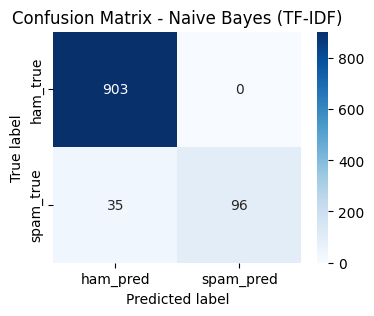

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = nb.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}\n")

print("Reporte de clasificación:")
print(classification_report(y_test, y_pred, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=['ham', 'spam'])
cm_df = pd.DataFrame(cm, index=['ham_true','spam_true'], columns=['ham_pred','spam_pred'])

print("\nMatriz de confusión:")
print(cm_df)

# Heatmap
plt.figure(figsize=(4,3))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Naive Bayes (TF-IDF)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

In [12]:
import numpy as np

# Obtener las palabras del vocabulario
feature_names = np.array(tfidf.get_feature_names_out())

# Log probabilidad por clase (coef_ en MultinomialNB)
class_labels = nb.classes_  # ['ham', 'spam']
log_probs = nb.feature_log_prob_

# Ordenar las palabras más relevantes para spam y ham
topn = 15  # top palabras a mostrar

spam_idx = np.argsort(log_probs[1])[::-1][:topn]
ham_idx  = np.argsort(log_probs[0])[::-1][:topn]

print("🔎 Palabras más asociadas a SPAM:")
for i in spam_idx:
    print(f"{feature_names[i]}  (score={log_probs[1][i]:.2f})")

print("\n🔎 Palabras más asociadas a HAM:")
for i in ham_idx:
    print(f"{feature_names[i]}  (score={log_probs[0][i]:.2f})")

🔎 Palabras más asociadas a SPAM:
free  (score=-6.40)
text  (score=-6.76)
txt  (score=-6.79)
mobile  (score=-6.81)
reply  (score=-6.87)
stop  (score=-6.88)
ur  (score=-6.94)
claim  (score=-6.96)
prize  (score=-7.00)
www  (score=-7.01)
new  (score=-7.13)
uk  (score=-7.13)
won  (score=-7.19)
cash  (score=-7.25)
urgent  (score=-7.27)

🔎 Palabras más asociadas a HAM:
ok  (score=-5.76)
ll  (score=-6.12)
just  (score=-6.13)
like  (score=-6.16)
come  (score=-6.17)
gt  (score=-6.17)
know  (score=-6.17)
lt  (score=-6.18)
got  (score=-6.22)
good  (score=-6.24)
time  (score=-6.25)
going  (score=-6.26)
home  (score=-6.26)
lt gt  (score=-6.27)
lor  (score=-6.33)


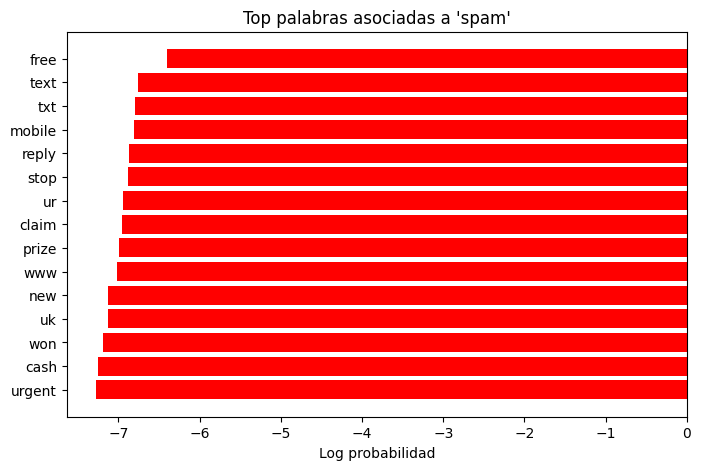

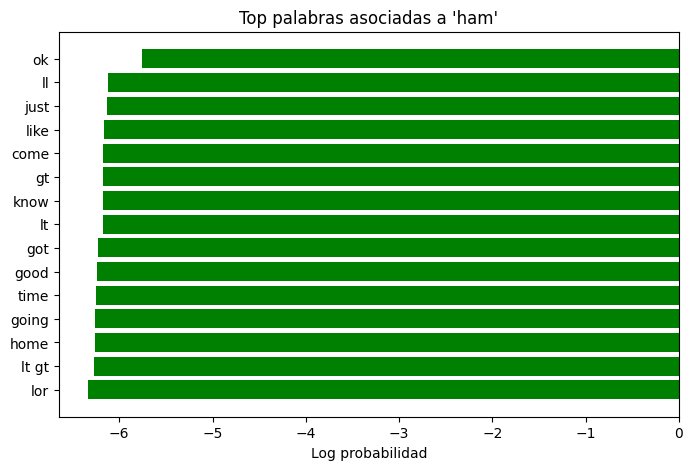

In [13]:
import matplotlib.pyplot as plt

def plot_top_words(class_idx, label, color):
    top_idx = np.argsort(log_probs[class_idx])[::-1][:15]
    top_features = feature_names[top_idx]
    top_scores = log_probs[class_idx][top_idx]

    plt.figure(figsize=(8,5))
    plt.barh(top_features[::-1], top_scores[::-1], color=color)
    plt.title(f"Top palabras asociadas a '{label}'")
    plt.xlabel("Log probabilidad")
    plt.show()

plot_top_words(1, "spam", "red")
plot_top_words(0, "ham", "green")

In [14]:
# Ejemplos manuales
nuevos_mensajes = [
    "Congratulations! You've won a free ticket to Bahamas. Call now!",
    "Hey, are we still meeting at 7 for dinner?",
    "URGENT! Your account has been suspended, click the link to restore access.",
    "Ok, I'll bring the documents tomorrow morning."
]

# Transformar usando el mismo vectorizador
X_new = tfidf.transform(nuevos_mensajes)

# Predecir etiquetas
preds = nb.predict(X_new)
probs = nb.predict_proba(X_new)

# Mostrar resultados
for msg, label, prob in zip(nuevos_mensajes, preds, probs):
    print(f"\n📩 Mensaje: {msg}")
    print(f"➡️ Clasificado como: {label.upper()} (Confianza: {max(prob):.2f})")


📩 Mensaje: Congratulations! You've won a free ticket to Bahamas. Call now!
➡️ Clasificado como: HAM (Confianza: 0.65)

📩 Mensaje: Hey, are we still meeting at 7 for dinner?
➡️ Clasificado como: HAM (Confianza: 1.00)

📩 Mensaje: URGENT! Your account has been suspended, click the link to restore access.
➡️ Clasificado como: HAM (Confianza: 0.50)

📩 Mensaje: Ok, I'll bring the documents tomorrow morning.
➡️ Clasificado como: HAM (Confianza: 0.99)


# Dashboard en Streamlit

In [16]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.6 MB/s eta 0:00:00


In [52]:
# Liberar el túnel en streamlit
from pyngrok import ngrok
ngrok.kill()

In [53]:
# Construir la app
%%writefile app.py
import streamlit as st
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# ====================
# Cargar modelo y vectorizador
# ====================
nb = joblib.load("modelo_spam.pkl")
tfidf = joblib.load("vectorizador_tfidf.pkl")
df = pd.read_csv("spam.csv", encoding="latin-1")  # dataset limpio de spam.csv

# Verificar nombres de columnas
print("Columnas originales:", df.columns.tolist())

# Mantener solo las columnas relevantes y renombrarlas
df = df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})

# Limpiar nulos y duplicados
df = df.dropna().drop_duplicates()

# Verificar
print("Columnas finales:", df.columns.tolist())
print("Primeros registros:\n", df.head(3).to_string(index=False))

# ====================
# Configuración de página
# ====================
st.set_page_config(page_title="Detector de Spam", page_icon="📩", layout="wide")
st.title("📩 Detector de Spam con Naive Bayes")
st.markdown("Este modelo clasifica mensajes como **Spam** o **Ham** y muestra un semáforo según confianza.")

# ====================
# Pestañas
# ====================
tab1, tab2, tab3 = st.tabs(["🔎 Clasificador", "📊 Métricas", "☁️ Nube de Palabras"])

# ====================
# 🔎 Clasificador con semáforo
# ====================
with tab1:
    st.subheader("Prueba el clasificador")
    mensaje = st.text_area("Escribe un mensaje aquí:", height=150)

    if st.button("Clasificar"):
        if mensaje.strip() != "":
            X_new = tfidf.transform([mensaje])
            pred = nb.predict(X_new)[0]
            prob = nb.predict_proba(X_new)[0]
            conf = max(prob)  # confianza máxima del modelo

            # Semáforo según confianza
            if conf >= 0.9:
                semaforo = "🟢"
                color_text = "✅"
                texto_resultado = f"{color_text} El mensaje parece muy seguro. (confianza: {conf:.2f})"
            elif conf >= 0.7:
                semaforo = "🟡"
                color_text = "⚠️"
                texto_resultado = f"{color_text} Posible SPAM, revisa el contenido del mensaje. (confianza: {conf:.2f})"
            else:
                semaforo = "🔴"
                color_text = "🚨"
                texto_resultado = f"{color_text} Mensaje muy inseguro, no entres en ningún link que contenga. (confianza: {conf:.2f})"

            # Mostrar resultado
            st.markdown(f"**Resultado:** {semaforo} {texto_resultado}")
        else:
            st.warning("⚠️ Por favor escribe un mensaje antes de clasificar.")

# ====================
# 📊 Métricas y matriz de confusión
# ====================
with tab2:
    st.subheader("Evaluación del modelo")

    # Vectorización del dataset completo
    X = tfidf.transform(df["text"])
    y = df["label"]
    y_pred = nb.predict(X)

    # Reporte de clasificación
    report = classification_report(y, y_pred, output_dict=True)
    df_report = pd.DataFrame(report).transpose()

    st.dataframe(df_report.style.background_gradient(cmap="Blues"))

    # Matriz de confusión
    cm = confusion_matrix(y, y_pred, labels=["ham", "spam"])
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["ham", "spam"], yticklabels=["ham", "spam"], ax=ax)
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    st.pyplot(fig)

# ====================
# ☁️ Nube de palabras
# ====================
with tab3:
    st.subheader("Nube de palabras por categoría")
    col1, col2 = st.columns(2)

    with col1:
        st.markdown("### HAM")
        text_ham = " ".join(df[df["label"] == "ham"]["text"].tolist())
        wordcloud_ham = WordCloud(width=400, height=300, background_color="white").generate(text_ham)
        fig, ax = plt.subplots()
        ax.imshow(wordcloud_ham, interpolation="bilinear")
        ax.axis("off")
        st.pyplot(fig)

    with col2:
        st.markdown("### SPAM")
        text_spam = " ".join(df[df["label"] == "spam"]["text"].tolist())
        wordcloud_spam = WordCloud(width=400, height=300, background_color="white", colormap="Reds").generate(text_spam)
        fig, ax = plt.subplots()
        ax.imshow(wordcloud_spam, interpolation="bilinear")
        ax.axis("off")
        st.pyplot(fig)

Overwriting app.py


In [54]:
import joblib

# Guardar modelo y vectorizador
joblib.dump(nb, "modelo_spam.pkl")
joblib.dump(tfidf, "vectorizador_tfidf.pkl")

['vectorizador_tfidf.pkl']

In [55]:
# ----------------------------------
# Configurar ngrok y ejecutar Streamlit
# ----------------------------------
from pyngrok import ngrok

# Autenticación de ngrok
ngrok.set_auth_token("30o7TsMuntI5miQaxLyoGfwaOCz_2Jj8aqZgJnKXZ3cVc8t4")

In [56]:
# Conectar ngrok al puerto 8501
public_url = ngrok.connect(addr=8501)
print(f"Tu dashboard público estará disponible en: {public_url}")

Tu dashboard público estará disponible en: NgrokTunnel: "https://4276d448f6e9.ngrok-free.app" -> "http://localhost:8501"


In [57]:
# Ejecutar Streamlit en modo headless
!streamlit run app.py --server.port 8501 --server.headless true




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.196.114.123:8501



Columnas originales: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Columnas finales: ['label', 'text']
Primeros registros:
 label                                                                                                                                                        text
  ham                                             Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
  ham                                                                                                                               Ok lar... Joking wif u oni...
 spam Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Columnas originales: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']
Columnas finales: ['label', 'text']
Primeros registros:
 label                                                                                 